# Data loading operations for ProstateX

## Loading the data

Here we will consider each modality (axial T2W and axial DWI) independently since masks are available for both.

In [123]:
import os
from glob import glob
from tqdm import tqdm,trange

from lib.dataoperations.lib.data_functions import *

import pylab

## Loading and aggregating

### Constructing the path dictionary + gathering median size and spacing

In [41]:
import nibabel as nib
import numpy as np
from itertools import combinations
from lib.utils import *
import SimpleITK as sitk

base_path = "/home/jose_almeida/data/PROSTATEx/ProstateX_resized"
path_dictionary = get_prostatex_path_dictionary(base_path)

size_dict,spacing_dict = get_size_spacing_dict(
    path_dictionary,["DWI","T2WAx"])

for k in size_dict:
    size_dict[k] = np.int32(
        np.median(np.array(size_dict[k]),axis=0))
    spacing_dict[k] = np.median(np.array(spacing_dict[k]),axis=0)

In [42]:
class Round(monai.transforms.MapTransform):
    def __init__(self,keys:List[str],n_digits:int=0)->monai.transforms.MapTransform:
        super().__init__(keys)
        self.keys = keys
        self.n_digits = n_digits

    def __call__(self, data: Mapping[Hashable,TensorOrNDarray]) -> Dict[Hashable,TensorOrNDarray]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = d[key]
        return d

    def round_arbitrary(self,x:torch.Tensor)->torch.Tensor:
        if isinstance(x,torch.Tensor):
            return torch.round(x,self.n_digits)
        if isinstance(x,np.ndarray):
            return np.round(x,self.n_digits)

label_path = "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-lesion/Prostatex0100_DWI_aggregated.nii.gz"
im_path = "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/DWI/Prostatex0100_CALC_BVAL.nii.gz"

x = im_path
X = nib.load(x)
fdata = X.get_fdata()
affine = X.affine

im = nib.Nifti1Image(fdata,affine)
o = "tmp.nii.gz"
nib.save(im,o)

print("Data type for original:",nib.load(x).get_fdata().dtype)
print("Data type for copy:",nib.load(o).get_fdata().dtype)

S = [2.00,2.00,3.00]

out_1 = monai.transforms.Compose([
    monai.transforms.LoadImaged(['image'])])({'image':x})

out_2 = monai.transforms.Compose([
    monai.transforms.LoadImaged(['image'])])({'image':o})

print(
    "Quantiles of data after LoadImaged:",
    np.quantile(out_1["image"]-out_2["image"],[0,0.05,0.5,0.95,1]))

out_1 = monai.transforms.Compose([
    monai.transforms.LoadImaged(['image']),
    monai.transforms.Spacingd(['image'],S)
])({'image':x})

out_2 = monai.transforms.Compose([
    monai.transforms.LoadImaged(['image']),
    monai.transforms.Spacingd(['image'],S)
])({'image':o})

print(
    "Quantiles of difference after Spacingd:",
    np.quantile(out_1["image"]-out_2["image"],[0,0.05,0.5,0.95,1]))


Data type for original: float64
Data type for copy: float64
Quantiles of data after LoadImaged: [0. 0. 0. 0. 0.]
Quantiles of difference after Spacingd: [0. 0. 0. 0. 0.]


(84, 128, 19)
0.0 0.0
0.0 133.0


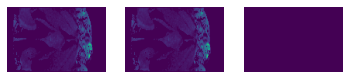

0.0 0.0
0.0 109.0


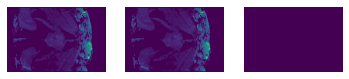

0.0 0.0
0.0 106.0


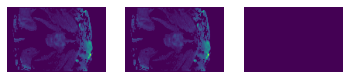

0.0 0.0
0.0 118.0


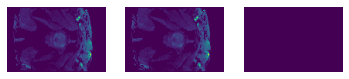

0.0 0.0
0.0 144.0


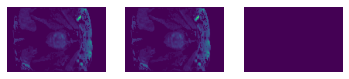

0.0 0.0
0.0 114.0


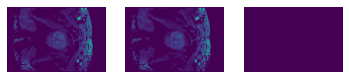

0.0 0.0
0.0 149.0


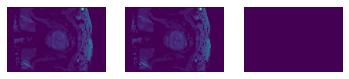

0.0 0.0
0.0 79.0


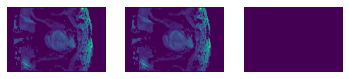

0.0 0.0
0.0 66.0


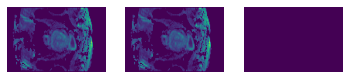

0.0 0.0
0.0 65.0


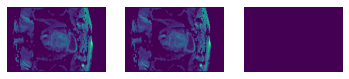

0.0 0.0
0.0 73.0


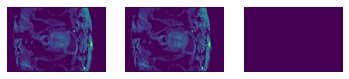

0.0 0.0
0.0 80.0


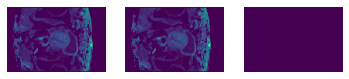

0.0 0.0
0.0 103.0


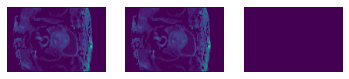

0.0 0.0
0.0 109.0


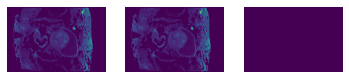

0.0 0.0
0.0 101.0


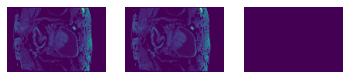

0.0 0.0
0.0 93.0


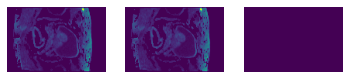

0.0 0.0
0.0 54.0


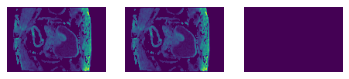

0.0 0.0
0.0 66.0


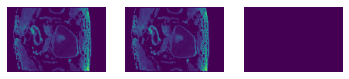

0.0 0.0
0.0 78.0


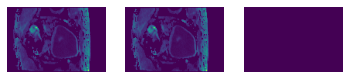

In [43]:
import matplotlib.pyplot as plt

im1 = nib.load(x).get_fdata()
im2 = nib.load(o).get_fdata()

print(im2.shape)

for i in range(im1.shape[-1]):
    D = im1[:,:,i]-im2[:,:,i]
    
    cmin = np.min([np.min(D),im1[:,:,i].min(),im2[:,:,i].min()])
    cmax = np.max([np.max(D),im1[:,:,i].max(),im2[:,:,i].max()])

    print(D.min(),D.max())
    print(np.min([im1[:,:,i],im2[:,:,i]]),np.max([im1[:,:,i],im2[:,:,i]]))
    g,ax = plt.subplots(1,3)
    ax[0].imshow(im1[:,:,i],vmin=cmin,vmax=cmax)
    ax[0].axis('off')

    ax[1].imshow(im2[:,:,i],vmin=cmin,vmax=cmax)
    ax[1].axis('off')

    ax[2].imshow(D,vmin=cmin,vmax=cmax)
    ax[2].axis('off')

    plt.show()

### Loading and aggregating gland labels

We have two types of labels in these data: gland labels and lesion labels. Any given scan could have been annotated by more than one radiologist and, for this reason, we have to aggregate labels in some manner. To do this, I have decided to simply average the labels, yielding softer labels at voxels which were labelled by a smaller proportion of radiologists as belonging to the object of interest. While there is a single gland each gland corresponds, intuitively to the one object of interest, there are multiple lesions labelled separately. This is problematic as they are not labelled in a particularly intuitive manner:

* lesion1 - lesion 1 by radiologist 1
* lesion2 - lesion 2 by radiologist 1
* lesion12 - lesion 1 by radiologist 2

Because of these considerations (retrieving average labels), I have processed them separately (using `aggregate-labels.py`) and saved them in a separate file.

### Small benchmarking of resize pipeline

After some minor tests, I have come to realise that combining MONAI I/O with TorchIO data transforms is the best solution. A caveat of this is, however, the fact that TorchIO requires all inputs in a given transform to have the same size (which may not always be the case). For this reason I unfold these transforms, i.e.:

Instead of a simple `torchio.transforms.Resize(include=t2w_keys,label_keys=t2w_keys[1:],target_shape=size_dict["T2WAx"])`, we have to combine three transforms, one for each image (original image, lesion segmentation map, prostate segmentation map). Even by doing this TorchIO still proves to be a faster solution than MONAI for these kinds of preprocessing steps.

In [44]:
import torchio

class Printd(monai.transforms.Transform):
    def __init__(self,w):
        self.w = w

    def __call__(self,X):
        print(self.w)
        return X

t2w_keys = ['T2WAx','T2WAx_gland_segmentations','T2WAx_lesion_segmentations']
dwi_keys = ['DWI','DWI_gland_segmentations','DWI_lesion_segmentations']
all_keys = t2w_keys + dwi_keys
intp = ["area","nearest","nearest"]
transforms_monai = [
    #torchio.transforms.Resample(include=t2w_keys,label_keys=t2w_keys[1:],target=spacing_dict["T2WAx"]),
    #torchio.transforms.Resample(include=dwi_keys,label_keys=dwi_keys[1:],target=spacing_dict["DWI"]),
    #torchio.transforms.Resize(include=[t2w_keys[0]],target_shape=size_dict["T2WAx"]),
    #torchio.transforms.Resize(include=[t2w_keys[1]],label_keys=[t2w_keys[1]],target_shape=size_dict["T2WAx"]),
    #torchio.transforms.Resize(include=[t2w_keys[2]],label_keys=[t2w_keys[2]],target_shape=size_dict["T2WAx"]),
    #torchio.transforms.Resize(include=[dwi_keys[0]],target_shape=size_dict["DWI"]),
    #torchio.transforms.Resize(include=[dwi_keys[1]],label_keys=[dwi_keys[1]],target_shape=size_dict["DWI"]),
    #torchio.transforms.Resize(include=[dwi_keys[2]],label_keys=[dwi_keys[2]],target_shape=size_dict["DWI"])
    ]

print(spacing_dict)
print(size_dict)

{'DWI': array([2., 2., 3.]), 'T2WAx': array([0.5, 0.5, 3. ])}
{'DWI': array([ 84, 128,  19], dtype=int32), 'T2WAx': array([384, 384,  21], dtype=int32)}


In [45]:
print(len(path_dictionary))
path_dict_list = [path_dictionary[k]
                  for k in path_dictionary
                  if all(m in path_dictionary[k] for m in all_keys)]
print(len(path_dict_list))

T = monai.transforms.Compose([
    monai.transforms.LoadImaged(all_keys),
    monai.transforms.AddChanneld(all_keys)])
d = monai.data.Dataset(path_dict_list,transform=T)

179
174


In [46]:
import time
times_1 = {
    "io":[],
    "transforms":[[] for _ in transforms_monai]}

for i in trange(len(d)):
    a = time.time()
    e = d[i]
    b = time.time()
    times_1["io"].append(b-a)

    shapes = []
    for k in e:
        try: shapes.append(e[k].shape)
        except: pass
    #print(shapes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:52<00:00,  3.31it/s]


In [ ]:
print(np.mean(times_1["io"]),np.quantile(times_1["io"],[0,0.25,0.5,0.75,1]))

pid = "Prostatex0075"
for pid in np.random.choice(len(d),size=10):
    for K in (t2w_keys,):
        e = d[pid]
        ims = [e[k][0] for k in K]
        a,b,c = ims
        for i in np.random.choice(a.shape[-1],size=5):
            sa,sb,sc = a[:,:,i],b[:,:,i],c[:,:,i]
            print(np.quantile(sb,[0.,0.25,0.5,0.75,1.0]))
            g,ax = plt.subplots(1,3)
            ax[0].imshow(sa)
            ax[1].imshow(sb)
            ax[2].imshow(sa * np.where(sb > 0.2,1,0.5))
            plt.show()

## Slicer

Here I implement a transform that returns $N$ slices from each input provided there are sufficient positive examples in them.

In [143]:
class RandomSlices(monai.transforms.RandomizableTransform):
    def __init__(self,keys:List[str],label_key:List[str],n:int=1,base:float=0.01):
        self.keys = keys
        self.label_key = label_key
        self.n = n
        self.base = base
    
    def __call__(self,X):
        X_label = torch.Tensor(X[self.label_key])
        c = torch.flatten(X_label,start_dim=1,end_dim=-2)
        c_sum = c.sum(1)
        total_class = torch.unsqueeze(c_sum.sum(1),-1)
        c_prop = c_sum/total_class + self.base
        slice_weight = c_prop.mean(0)
        slice_idxs = torch.multinomial(slice_weight,self.n)
        return {k:torch.Tensor(np.take(X[k],slice_idxs,-1))
                for k in self.keys}
    
def collate_last_slice(X):
    def swap(x):
        return x.swapaxes(-1,0).swapaxes(-1,1).swapaxes(2,3)
    example = X[0]
    if isinstance(example,list):
        output = []
        for elements in zip(*X):
            elements = [swap(x) for x in elements]
            output.append(torch.cat(elements))
    elif isinstance(example,dict):
        keys = list(example.keys())
        output = {}
        for k in keys:
            elements = [x[k] for x in X]
            elements = [swap(x) for x in elements]
            output[k] = torch.cat(elements)
    elif isinstance(example,torch.Tensor):
        output = torch.cat([swap(x) for x in X])
    
    return output
    
rs = RandomSlices(dwi_keys,dwi_keys[1],8)
O = rs(e)
#O = [O[k] for k in O]
o = collate_last_slice((O,))

print([o[k].shape for k in o])

[torch.Size([8, 1, 84, 128]), torch.Size([8, 1, 84, 128]), torch.Size([8, 1, 84, 128])]


## Segmentation map to object location

Here I implement:

1. A transform that converts a segmentation map with $d$ dimensions into an object location map characterised by $2*d$ channels: object shift from the beginning of the origin of the cell and the object bounding box dimensions
2. A transform that calculates the necessary anchor deformation to detection an object given the bounding box description in 1 and anchors

I will probably do this as a separate and prior processing step as it can potentially become unfeasible to do it online (too time consuming for 3D).

In [163]:
import numpy as np
import nibabel as nib
import cv2
from skimage import measure

import pylab
import matplotlib.pyplot as plt

def value_range(x):
    return x.min(),x.max()

def mask_to_bb_map(img,output_shape):
    labelled_image = measure.label(img)
    sh = np.array(labelled_image.shape)
    lsh = len(sh)
    output_sh = np.array(output_shape)
    rel_sh = sh/output_sh
    uniq = np.unique(labelled_image)
    uniq = uniq[uniq != 0]
    
    output = np.zeros([1+lsh*2,*output_sh])
    for u in uniq:
        C = np.where(labelled_image == u)
        bb = np.array([value_range(c) for c in C])
        center = np.mean(bb,1)
        bb_out = bb/sh[:,np.newaxis]
        center_out = center/rel_sh
        center_coords = np.floor(center_out)
        center_adj = center_out - center_coords
        center_coords = np.int32(center_coords)
        bb_dimensions = bb_out[:,1] - bb_out[:,0]
        E = np.concatenate([[1],center_adj,bb_dimensions])

        if len(C) == 2:
            output[:,center_coords[0],center_coords[1]] = E
        elif len(C) == 3:
            c = center_coords
            output[:,c[0],c[1],c[2]] = E
    
    return output

def mask_to_bb(img):
    labelled_image = measure.label(img)
    uniq = np.unique(labelled_image)
    uniq = uniq[uniq != 0]
    
    bb_vertices = []
    for u in uniq:
        C = np.where(labelled_image == u)
        bb = np.array([value_range(c) for c in C])
        if np.all(bb[:,1] == bb[:,0]) == False:
            bb_vertices.append(bb)

    return bb_vertices

def bb_mask_to_coords(img,shape):
    reconstructed_centers = []
    reconstructed_dimensions = []
    sh = np.array(img.shape)[1:]
    lsh = sh.size
    shape = np.array(shape)
    rel_sh = shape/sh
    centers = np.array(np.where(img[0,:,:] > 0)).T
    for center in centers:

        center_map = output[1:(1+lsh)]
        center_adj = [x[tuple(center)] for x in center_map]
        center_rec = np.array((center + center_adj).T*rel_sh)
        reconstructed_centers.append(center_rec)

        bb_map = output[(1+lsh):]
        bb_dim_rec = np.array([x[tuple(center)] for x in bb_map])
        bb_dim_rec = bb_dim_rec * shape
        reconstructed_dimensions.append(bb_dim_rec)

    return reconstructed_centers,reconstructed_dimensions

In [164]:
label_path = "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-gland/Prostatex0100_T2WAx_aggregated.nii.gz"

label_image = nib.load(label_path).get_fdata()

A = 100
x,y,z = np.where(label_image>0)
label_image[x-A,y-A,z] = 1
label_image[x+A,y+A,z] = 1

### Segmentation mask to bounding box and back (2D case)

The functions in the code block above have been generalized and work equally well in 2D and 3D. First I apply them to a 2D image.

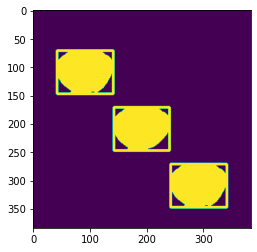

In [165]:
X = label_image[:,:,8]

img = X
output_shape = [32,32]

output = mask_to_bb_map(img,output_shape)
rec_centers,rec_dims = bb_mask_to_coords(output,X.shape)

image_plot = np.uint8(X[:,:].T).copy()
for rec_center,rec_dim in zip(rec_centers,rec_dims):
    upper_corner = tuple(np.int32(rec_center - rec_dim/2))
    lower_corner = tuple(np.int32(upper_corner + rec_dim))
    cv2.rectangle(
        image_plot,upper_corner[:2],lower_corner[:2],(1),3)

plt.imshow(image_plot)

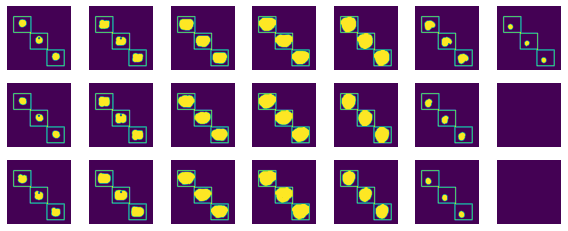

In [166]:
pylab.rcParams['figure.figsize'] = (10.0, 4.0)

X = label_image

img = X
output_shape = [32,32,20]

output = mask_to_bb_map(img,output_shape)
rec_centers,rec_dims = bb_mask_to_coords(output,X.shape)

div = 3
g,ax = plt.subplots(div,int(np.ceil(X.shape[-1]/div)))
for i in range(X.shape[-1]):
    image_plot = np.uint8(X[:,:,i].T).copy()
    for rec_center,rec_dim in zip(rec_centers,rec_dims):
        upper_corner = tuple(np.int32(rec_center - rec_dim/2))
        lower_corner = tuple(np.int32(upper_corner + rec_dim))
        if upper_corner[-1] <= i and lower_corner[-1] >= i:
            cv2.rectangle(
                image_plot,upper_corner[:2],lower_corner[:2],(1),3)

    ax[i%div,int(i//div)].imshow(image_plot)
    ax[i%div,int(i//div)].set_axis_off()

plt.show()

### Bounding box map and anchors to adjusted anchors and back

Given a set of anchors - otherwise known as bounding box priors - at each position in the bounding box map, we can calculate the amount of necessary (rigid and anysotropic) deformation necessary to resize them. Since I know (beforehand) that the prostate, for the images above, is supposed to be $\approx[100,100,18]$, I set two different anchors - $[90,90,14]$ and $[110,110,20]$. 

As such, at each individual pixel/voxel, there is an anchor which contains or not the prostate (the object). This measure of object colocation - also known as the anchor's "objectness" - is calculated as the overlap between an anchor and the bounding box of an object as measured by the intersection over the union (IoU) between both. Below a given threshold (let's assume $IoU < 0.5$) I assume that the anchor does not capture the box. For any other case ($IoU \geq 0.5$) I assume the anchor captures the object. My intention is to do all anchor calculations and adjustments online.

The simples way to calculate the IoU between two non-rotated bounding boxes is to:
1. Describe each bounding box as two of its vertices ($v_{min}$ as the top left vertex and $v_{max}$ as the bottom right vertex)
2. Calculate the vertices of the intersection box (the maximum coordinate values for both $v_{min}$ and the minimum coordinate values for $v_{max}$)
3. Calculate the area of the intersection box and of both bounding boxes (the bounding box dimensions can be used for this)
4. Calculate the ratio between the intersection (area of the intersection box) and the union ($\mathrm{area}_1 + \mathrm{area}_2 - \mathrm{area_{intersection}}$)

For this application (calculating IoU between an arbitrary number of anchors and bounding boxes), rather than a bounding box map, it is more practical to have an array of bounding boxes in long format. 

The outcome of this process is a set of positive anchors which fulfill the following set of criteria:

1. $IoU \geq 0.5$
2. $\mathrm{Distance}(\mathrm{object\ center},\mathrm{anchor\ center}) \leq 1$

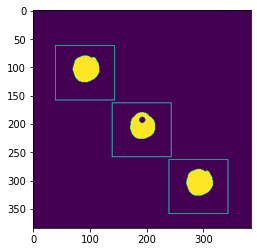

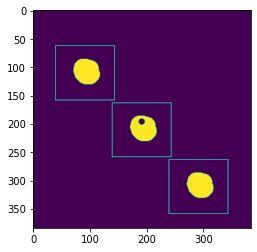

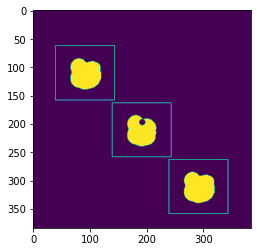

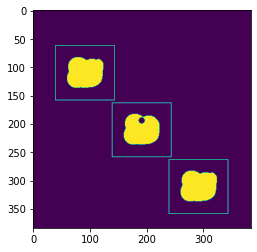

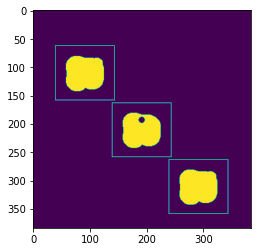

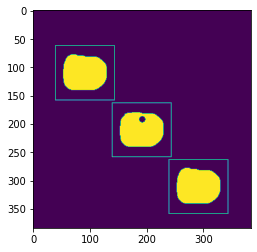

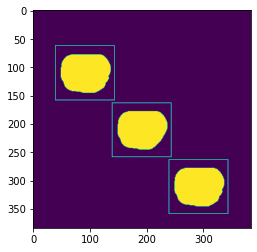

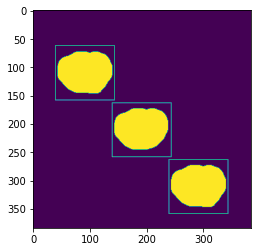

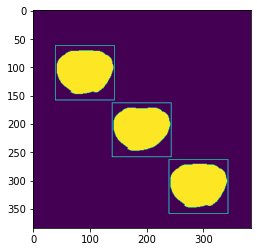

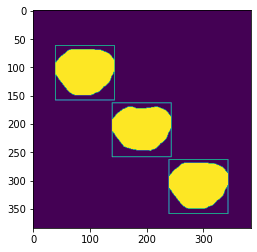

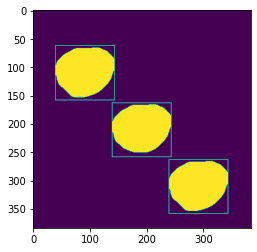

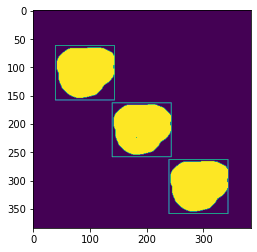

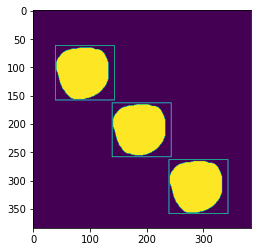

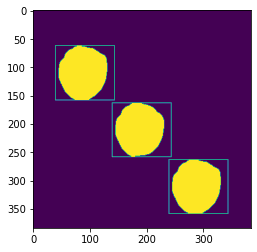

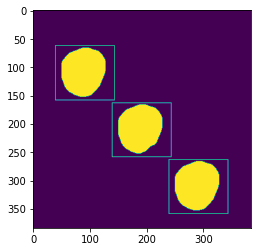

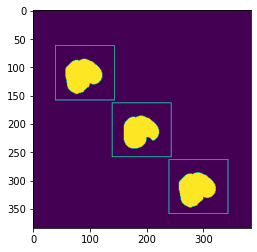

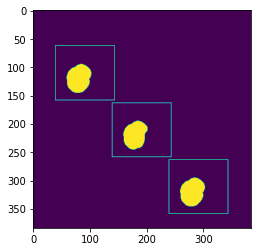

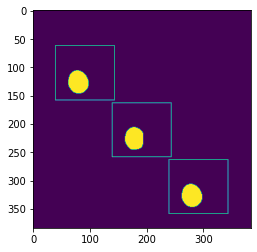

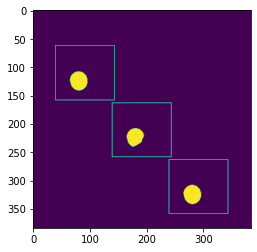

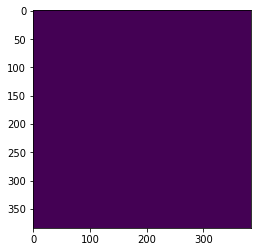

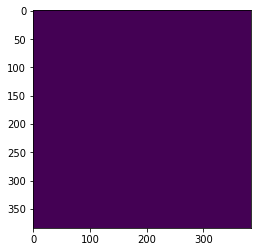

In [167]:
from itertools import product

class MaskToAdjustedAnchors:
    def __init__(self,anchor_sizes,input_sh,output_sh,iou_thresh):
        self.anchor_sizes = [np.array(x) for x in anchor_sizes]
        self.input_sh = input_sh
        self.output_sh = np.array(output_sh)
        self.iou_thresh = iou_thresh

        self.setup_long_anchors()
    
    def setup_long_anchors(self):
        image_sh = np.array(self.input_sh)
        self.rel_sh = image_sh / self.output_sh

        long_coords = []
        for c in product(
            *[np.arange(x) for x in self.output_sh]):
            long_coords.append(c)

        self.long_coords = np.array(long_coords)
        rel_anchor_sizes = [x/self.rel_sh
                            for x in self.anchor_sizes]

        self.long_anchors = []
        for rel_anchor_size in rel_anchor_sizes:
            # adding 0.5 centres the bounding boxes in each cell
            long_anchor_rel = [
                long_coords-rel_anchor_size/2 + 0.5,
                long_coords+rel_anchor_size/2 + 0.5]
            self.long_anchors.append(
                np.stack(long_anchor_rel,axis=-1))

    def __call__(self,bb_vertices):
        bb_vertices = np.array(bb_vertices)
        rel_bb_vert = bb_vertices / self.rel_sh[
            np.newaxis,:,np.newaxis]
        output = np.zeros([7*len(self.long_anchors),*self.output_sh])
        for I,long_anchor in enumerate(self.long_anchors):
            anchor_size = long_anchor[0,:,1] - long_anchor[0,:,0]
            for i in range(rel_bb_vert.shape[0]):
                rel_bb_size = np.subtract(
                    rel_bb_vert[i,:,1],
                    rel_bb_vert[i,:,0])
                rel_bb_size_adj = rel_bb_size/anchor_size
                center = np.mean(
                    rel_bb_vert[i,:,:],axis=-1)
                intersects = np.logical_and(
                    np.all(
                        long_anchor[:,:,1]>rel_bb_vert[i,:,0],axis=1),
                    np.all(
                        long_anchor[:,:,0]<rel_bb_vert[i,:,1],axis=1))
                inter_tl = np.maximum(
                    long_anchor[:,:,0],rel_bb_vert[i,:,0])
                inter_br = np.minimum(
                    long_anchor[:,:,1],rel_bb_vert[i,:,1])
                inter_dim = inter_br - inter_tl
                inter_vol = np.prod(inter_dim,axis=-1)
                anchor_dim = long_anchor[:,:,1]-long_anchor[:,:,0]
                bb_dim = np.subtract(
                    rel_bb_vert[i:(i+1),:,1],
                    rel_bb_vert[i:(i+1),:,0])
                anchor_vol = np.prod(anchor_dim,axis=-1)
                bb_vol = np.prod(bb_dim,axis=-1)
                vol_union = anchor_vol+bb_vol-inter_vol
                iou = inter_vol / vol_union
                intersection_idx = np.logical_and(
                    iou>self.iou_thresh,intersects)
                box_coords = self.long_coords[intersection_idx]
                iou = iou[intersection_idx]

                center_adjustment = center-(box_coords+0.5)
                distance_idx = np.all(np.abs(center_adjustment) < 1,axis=1)

                iou = iou[distance_idx]
                box_coords = box_coords[distance_idx]
                center_adjustment = center_adjustment[distance_idx]

                for j in range(box_coords.shape[0]):
                    idx = tuple(
                        [tuple([k+I*len(self.long_anchors) for k in range(7)]),
                         *box_coords[j]])
                    v = np.array(
                        [iou[j],*center_adjustment[j],*rel_bb_size_adj])
                    output[idx] = v

        return output
    
    def adjusted_anchors_to_bb_vertices(self,anchor_map):
        top_left_output = []
        bottom_right_output = []
        for i in range(len(self.anchor_sizes)):
            anchor_size = anchor_sizes[i]
            rel_anchor_size = np.array(anchor_size)
            sam = anchor_map[(i*7):(i*7+7)]
            coords = np.where(sam[0]>0)
            adj_anchors_long = np.zeros([len(coords[0]),7])
            for j,coord in enumerate(zip(*coords)):
                center_idxs = tuple([tuple([k for k in range(7)]),*coord])
                v = sam[center_idxs]
                adj_anchors_long[j,:] = v
            correct_centers = np.add(
                adj_anchors_long[:,1:4]+0.5,np.stack(coords,axis=1))
            correct_centers = correct_centers * self.rel_sh
            correct_dims = np.multiply(
                adj_anchors_long[:,4:],rel_anchor_size)
            top_left = correct_centers - correct_dims/2
            bottom_right = correct_centers + correct_dims/2
            top_left_output.append(top_left)
            bottom_right_output.append(bottom_right)
        return top_left_output,bottom_right_output

output_sh = [32,32,10]
anchor_sizes = [[90,90,14],[110,110,20],[100,100,18]]
iou_thresh = 0.5
bb_vertices = mask_to_bb(label_image)
input_sh = label_image.shape
m = MaskToAdjustedAnchors(anchor_sizes[0:1],input_sh,output_sh,iou_thresh)
output = m(bb_vertices)
O = m.adjusted_anchors_to_bb_vertices(anchor_map=output)

top_left_v,bottom_right_v = O

for dim in range(label_image.shape[-1]):
    d = np.uint8(label_image[:,:,dim].T)
    for i in range(len(top_left_v)):
        tlvs = top_left_v[i]
        brvs = bottom_right_v[i]
        for tlv,brv in zip(tlvs,brvs):
            tlv = np.int32(tlv)
            brv = np.int32(brv)
            if tlv[2] <= dim and brv[2] >= dim:
                cv2.rectangle(d,tuple(tlv[:2]),tuple(brv[:2]),1)
    plt.imshow(d)
    plt.show()

### Benchmarking - is online feasible?

The final step is assessing whether it is feasible to perform this online (i.e. during training) without adding significant overhead. Firstly I have to check the following: 

* What is the size distribution of objects? This will affect anchor number and dimension
* What is the object distance distribution (particularly between lesions)? This will affect the dimension of the output map

To assess both of these issues I make use of the available ProstateX data.

In [240]:
from glob import glob
from tqdm import tqdm

mask_paths = {
    "gland":{
        "T2WAx":glob(
            "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-gland/*T2WAx*.nii.gz"),
        "DWI": glob(
            "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-gland/*DWI*.nii.gz")},
    "lesion":{
        "T2WAx":glob(
            "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-lesion/*T2WAx*.nii.gz"),
        "DWI":glob(
            "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-lesion/*DWI*.nii.gz")}}
all_input_sh = {
    "gland":{"T2WAx":[],"DWI":[]},
    "lesion":{"T2WAx":[],"DWI":[]}}
all_masks = {"gland":{"T2WAx":[],"DWI":[]},
             "lesion":{"T2WAx":[],"DWI":[]}}
for region in mask_paths:
    for mod in mask_paths[region]:
        print(region,mod)
        for path in tqdm(mask_paths[region][mod]):
            f = nib.load(path).get_fdata()
            all_masks[region][mod].append(
                mask_to_bb(f))
            all_input_sh[region][mod].append(f.shape)

gland T2WAx


100%|██████████| 179/179 [00:40<00:00,  4.44it/s]


gland DWI


100%|██████████| 175/175 [00:03<00:00, 58.28it/s]


lesion T2WAx


100%|██████████| 179/179 [00:39<00:00,  4.53it/s]


lesion DWI


100%|██████████| 175/175 [00:02<00:00, 73.55it/s]


In [248]:
sizes = {"gland":{"T2WAx":[],"DWI":[]},
         "lesion":{"T2WAx":[],"DWI":[]}}
distances = {"gland":{"T2WAx":[],"DWI":[]},
             "lesion":{"T2WAx":[],"DWI":[]}}
shapes = {"gland":{"T2WAx":[],"DWI":[]},
          "lesion":{"T2WAx":[],"DWI":[]}}
for region in all_masks:
    for mod in all_masks[region]:
        shapes[region][mod] = np.median(
            all_input_sh[region][mod],axis=0)
        for bb in all_masks[region][mod]:
            if len(bb) > 0:
                bb = np.array(bb)
                diff = bb[:,:,1] - bb[:,:,0] + 1
                sizes[region][mod].extend([x for x in diff])

                n = bb.shape[0]
                if n > 1:
                    for i in range(n):
                        for j in range(n):
                            if i != j:
                                Ds = []
                                for v in [0,1]:
                                    D = np.abs(bb[i,:,v]-bb[j,:,v])
                                    Ds.append(D)
                                D = np.array(Ds)
                                D = D[D.sum(1).argmin()]
                                distances[region][mod].append(D)

In [253]:
size_clusters = {
    "gland":{"T2WAx":[],"DWI":[]},
    "lesion":{"T2WAx":[],"DWI":[]}}
minimum_distances = {
    "gland":{"T2WAx":[],"DWI":[]},
    "lesion":{"T2WAx":[],"DWI":[]}}

from sklearn.cluster import OPTICS

clust = OPTICS(min_samples=15)
for region in sizes:
    for mod in sizes[region]:
        s = np.array(sizes[region][mod])
        if region == "gland":
            s = s[s.prod(1)>9]
        d = np.array(distances[region][mod])
        x = clust.fit_predict(s.astype(np.float32))
        print("Size clusters for {},{}:".format(region,mod))
        for i,c in enumerate(np.unique(x)):
            centroid = np.median(s[x == c],0)
            size_clusters[region][mod].append(centroid)
            print("\tCluster {}={}".format(i,centroid))
        if region == "lesion":
            print("Distance minimum for {},{}:".format(region,mod))
            centroid = d[d.sum(1).argmin()]
            print("\tMin dist={}".format(centroid))
            minimum_distances[region][mod] = centroid


Size clusters for gland,T2WAx:
	Cluster 0=[115.  99.  16.]
	Cluster 1=[118.  94.  15.]
	Cluster 2=[95. 74. 12.]
Size clusters for gland,DWI:
	Cluster 0=[29. 23. 16.]
	Cluster 1=[32. 26. 18.]
Size clusters for lesion,T2WAx:
	Cluster 0=[30. 28.  4.]
	Cluster 1=[25. 25.  4.]
	Cluster 2=[18. 17.  3.]
	Cluster 3=[9. 9. 1.]
Distance minimum for lesion,T2WAx:
	Min dist=[0 3 4]
Size clusters for lesion,DWI:
	Cluster 0=[8. 7. 4.]
	Cluster 1=[5. 5. 3.]
	Cluster 2=[3. 2. 1.]
Distance minimum for lesion,DWI:
	Min dist=[0 1 4]


In [260]:
import time
for region in size_clusters:
    for mod in size_clusters[region]:
        input_sh = shapes[region][mod].astype(np.int32)
        anchors = size_clusters[region][mod]
        m = minimum_distances[region][mod]
        if len(m) == 0:
            output_sh = {
                "T2WAx":[32,32,10],"DWI":[16,16,10]}[mod]
        else:
            M = np.max(minimum_distances[region][mod])
            output_sh = np.int32(input_sh / M)
        times = []
        for _ in range(10):
            m = MaskToAdjustedAnchors(anchor_sizes,input_sh,output_sh,iou_thresh)
            for bb_vertices in all_masks[region][mod]:
                if len(bb_vertices) > 0:
                    a = time.time()
                    output = m(bb_vertices)
                    b = time.time()
                    times.append(b-a)

        print(output_sh,np.mean(times))

[32, 32, 10] 0.0035616874694824217
[16, 16, 10] 0.0009729563849312919
[96 96  5] 0.022344463097982565
[21 32  4] 0.001459512491335814
